# Part I. Functional connectivity within subjects (standard FC)


<img src="http://drive.google.com/uc?export=view&id=1GPJ8XWcvqHr9NnyVm2DubagzV7cBPvsR" style="height:250px"/>

- The correlation of the time course of activity from the seed voxel with the time series from the target voxel is a proxy for the functional connectivity between those areas. 
- We have strong hypotheses about how information should flow in the brain. So instead of doing these analyses for the whole brain we do them for specific regions (`==ROI==pairs of voxels`).
- BOLD signal is noisy, remove noise and correct for movement $\rightarrow$ residuals. We do this analysis with the residuals, which is a proxy for the actual BOLD signal. 

> In other words, FC is a measure of the temporal correlation across different brain areas within a subjects brain.

See the [brainiak connectivity tutortial - 08](https://brainiak.org/tutorials/08-connectivity/) for more info.



<font color=red></font>

In [1]:
import warnings
import h5py
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
import numpy as np
import pandas as pd 

from nilearn import datasets, image
from nilearn import surface
from nilearn import plotting
from nilearn import input_data

from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nibabel.affines import apply_affine
import nibabel as nib
import time

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 
import scipy.io as sio
from scipy import stats
from numpy.linalg import inv
from numpy import inf


# import own functions
import utils
reload(utils)

sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

In [2]:
path = '/Users/Daphne/data/'

# mask_nii is the functional mask, this selects the brain voxels
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 
# this where we plot our mask ON (sometimes called brain_nii) - the anatomical/structural image
mean_nii = nib.load(os.path.join(path, 'mean.nii')) 

# inverse of the affine matrix: mni2cor
inv_affine = inv(mask_nii.affine) # get the transformation matrix

# load mask and get voxel coordinates
mask_arr = np.load(path+'mask_arr.npy') # all masks are the same
mask_mat = mask_arr[0] # so we can pick any one from the array
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows

## A note on the data

- `all_corr_matrices_asym`: see function `correlate_one_sub` in `utils.py`

---

- `all_corr_matrices_sym`: creates a symmetric matrix

--- 

```Python
all_corr_matrices_sym = []

all_roi_voxels = encoding_voxels + updating_voxels # combine voxel indices


for i in range(num_subjects):
    # select residuals for one subject
    R = residuals[:, :, i] # all TRs, all voxels, one subject
    
    all_roi_time_series = R[:, all_roi_voxels]
    
    df = pd.DataFrame(all_roi_time_series) # convert to df
    sym_corr_matrix = df.corr('pearson') # correlate all cols
    
    
    all_corr_matrices_sym.append(sym_corr_matrix)

```

---

- `residuals_roi_voxels`: subset of voxel time series from all voxels 

---

```Python
residuals_roi_voxels = []

all_roi_voxels = encoding_voxels + updating_voxels # combine voxel indices

for i in range(num_subjects):
    # select residuals for one subject
    R = residuals[:, :, i] # all TRs, all voxels, one subject
    
    all_roi_time_series = R[:, all_roi_voxels] # take only voxels of interest
    print(all_roi_time_series.shape) # @jiajia this should be: (1698, 14)
    
    residuals_roi_voxels.append(all_roi_time_series)

```

In [3]:
# ==== LOAD files that Jiajia ran on cluster ===
FC_all_corr_matrices_asym = np.load(path+'all_corr_matrices.npy') 
FC_all_corr_matrices_sym = np.load(path+'all_corr_matrices_sym.npy')

residuals_roi_voxels = np.load(path+'residuals_roi_voxels.npy')

In [4]:
FC_all_corr_matrices_asym.shape # subjects, 

(8, 7, 7)

In [5]:
FC_all_corr_matrices_sym .shape

(8, 14, 14)

In [6]:
residuals_roi_voxels.shape # TRs, voxels, subjects

(1698, 14, 8)

# 1. Pick a seed

In [7]:
# Theory ENCODING voxels
R_IFG_Tri_E = [42, 28, 26]
L_Insula_E = [-30, 28, 2]
R_DMPFC_E = [6, 38, 40]
L_IFG_Tri_E = [-50, 44, 12]
L_MTG_E = [-64, -50, 4]
R_MTG_E = [58, -36, 8]
Roi_1A = [48, 34,  8]

# Theory UPDATING voxels
R_IFG_Oper_U = [48, 12, 28]
L_PPC_U = [-56, -32, 46]
R_IFG_Tri_U = [52, 38, 16]
R_AG_U = [32, -60, 34]
L_Fusiform_U = [-40, -58, -12]
L_IFG_Oper_U = [-42, 4, 28]
R_PHC_U = [26, -42, -8]

# control voxels
# tip: can always try the contralateral ROIs: [-x y z]
L_lingual = [2, -86, 4]
Occipital = [-36 -88 -12]

In [8]:
# create dictionary to map points to roi names
encoding_roi_dict = {'R_IFG_Tri_E':R_IFG_Tri_E, 'L_Insula_E':L_Insula_E, 'R_DMPFC_E':R_DMPFC_E,
                     'L_IFG_Tri_E':L_IFG_Tri_E, 'L_MTG_E':L_MTG_E, 'R_MTG_E':R_MTG_E, 'Roi_1A ':Roi_1A 
                    }

updating_roi_dict = {'R_IFG_Oper_U':R_IFG_Oper_U, 'L_PPC_U':L_PPC_U, 'R_IFG_Tri_U':R_IFG_Tri_U,
                     'R_AG_U':R_AG_U, 'L_Fusiform_U':L_Fusiform_U, 'L_IFG_Oper_U':L_IFG_Oper_U, 
                     'R_PHC_U':R_PHC_U
                    }

# combine in one for plotting later
EU_dict = {**encoding_roi_dict, **updating_roi_dict}

# map control voxels to names
control_dict = {'control vox (left lingual)':L_lingual, 'control vox (Occipital)':Occipital}

In [79]:
len(encoding_roi_dict) # a mapping between the regions and the 

7

In [10]:
# get the voxel indices for the theory encoding and theory updating regions
encoding_voxels = []
updating_voxels = []

# ENCODING ROIs
for key, value in encoding_roi_dict.items():

    coords_mni = value
    print(coords_mni)
    
    coords_natv = apply_affine(aff=inv_affine, pts=coords_mni) # from mni2cor
    vox_num = utils.get_vox_from_coords(coords_mat, coords_natv) # corresponding voxel
    
    encoding_voxels.append(vox_num)

# UPDATING ROIs
for key, value in updating_roi_dict.items():

    coords_mni = value
    print(coords_mni)
    
    coords_natv = apply_affine(aff=inv_affine, pts=coords_mni) # from mni2cor
    vox_num = utils.get_vox_from_coords(coords_mat, coords_natv) # corresponding voxel
    
    updating_voxels.append(vox_num)

[42, 28, 26]
The coordinates correspond to voxel: 146217.
[-30, 28, 2]
The coordinates correspond to voxel: 89655.
[6, 38, 40]
The coordinates correspond to voxel: 175423.
[-50, 44, 12]
The coordinates correspond to voxel: 114273.
[-64, -50, 4]
The coordinates correspond to voxel: 91966.
[58, -36, 8]
The coordinates correspond to voxel: 102081.
[48, 34, 8]
The coordinates correspond to voxel: 104340.
[48, 12, 28]
The coordinates correspond to voxel: 150132.
[-56, -32, 46]
The coordinates correspond to voxel: 184359.
[52, 38, 16]
The coordinates correspond to voxel: 123560.
[32, -60, 34]
The coordinates correspond to voxel: 160565.
[-40, -58, -12]
The coordinates correspond to voxel: 53783.
[-42, 4, 28]
The coordinates correspond to voxel: 149930.
[26, -42, -8]
The coordinates correspond to voxel: 63462.


## 2.1 Do a ttest 

---

`stats.ttest_1samp` replicates the matlab [ttest(x) function](https://www.mathworks.com/help/stats/ttest.html#btrj1bc):
(One-sample t-test)

- $H_0$: data in x comes from a normal distribution with mean equal to zero (`popmean=0`) and unknown variance, using the one-sample t-test.
- $H_A$: population distribution does not have a mean equal to zero. The result h is 1 if the test rejects the null hypothesis at the 5% significance level, and 0 otherwise.

---

In [16]:
# we have the r values for all subjects
FC_all_corr_matrices_asym.shape

(8, 7, 7)

In [18]:
# we have the r values for all subjects
FC_all_corr_matrices_sym.shape

(8, 14, 14)

In [17]:
# lets do a ttest to collapse them into a single matrix
FC_tstats_asym, FC_p_asym = stats.ttest_1samp(np.arctanh(FC_all_corr_matrices_asym), popmean=0) # do the ttest

In [19]:
# lets do a ttest to collapse them into a single matrix
FC_tstats_sym, FC_p_sym = stats.ttest_1samp(np.arctanh(FC_all_corr_matrices_sym), popmean=0) # do the ttest

## 2.2 Display t statistics and use p values for thresholding

In [25]:
FC_tstats_asym.shape 

(7, 7)

In [26]:
FC_tstats_sym.shape # for the connectome

(14, 14)

In [44]:
def get_significant_stats(pvalues, tstats, alpha=0.01):

    '''
    Given an nd array of tstats and pvalues, return only the t statistics < alpha (significance level) 
    '''
    
    # make empty matrix for the significant t stats
    sig_M = np.zeros(pvalues.shape)

    # take indices of p values < alpha
    indices = np.where(pvalues < alpha)

    # get these t stats
    selected_tstats = tstats[indices]

    # map them in the right place
    sig_M[indices] = selected_tstats
    
    return sig_M

In [46]:
M_sig_asym = get_significant_stats(pvalues=FC_p_asym, tstats=FC_tstats_asym, alpha=0.01)

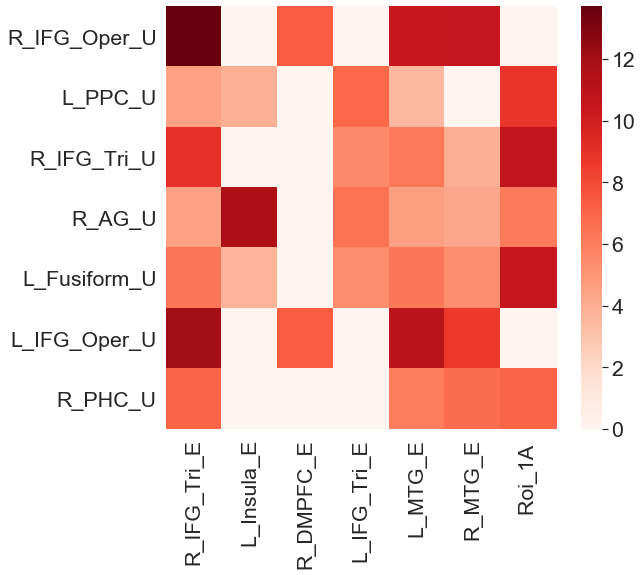

In [69]:
f, ax = plt.subplots(1,1, figsize = (9, 8), dpi=70)


sns.set(font_scale=2)
sns.heatmap(M_sig_asym, 
            cmap='Reds',
            xticklabels=encoding_roi_dict.keys(),
            yticklabels=updating_roi_dict.keys(),
            axes=ax,
            );

In [48]:
M_sig_sym = get_significant_stats(pvalues=FC_p_sym, tstats=FC_tstats_sym, alpha=0.01)

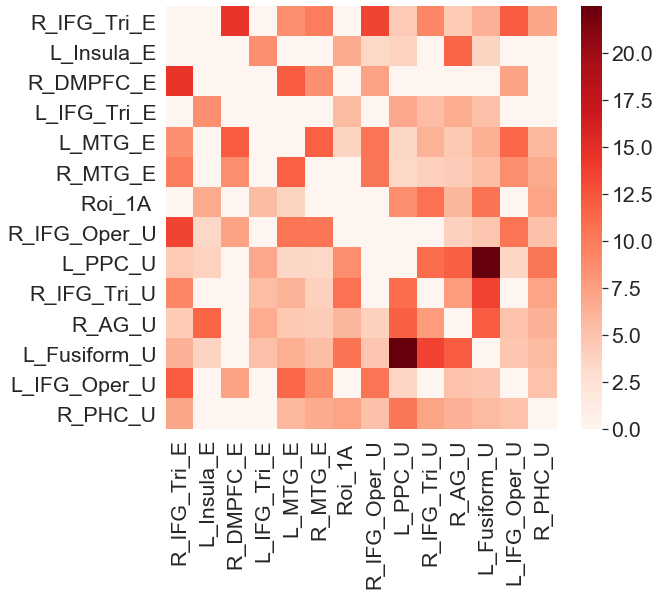

In [68]:
f, ax = plt.subplots(1,1, figsize = (9, 8), dpi=70)

sns.set(font_scale=2)
sns.heatmap(M_sig_sym, 
            cmap='Reds',
            xticklabels=EU_dict.keys(),
            yticklabels=EU_dict.keys(),
            axes=ax,
            );

## 2.3 Display connectome

<font color=red>TODO: check if this is correct (meaning the order of the voxels etc) > YES</font>


[plot_connectome source code](https://github.com/nilearn/nilearn/blob/0017a75ec9574477f5b5a5d039723c2a47cae2f5/nilearn/plotting/img_plotting.py#L1224)

In [82]:
??plotting.plot_connectome

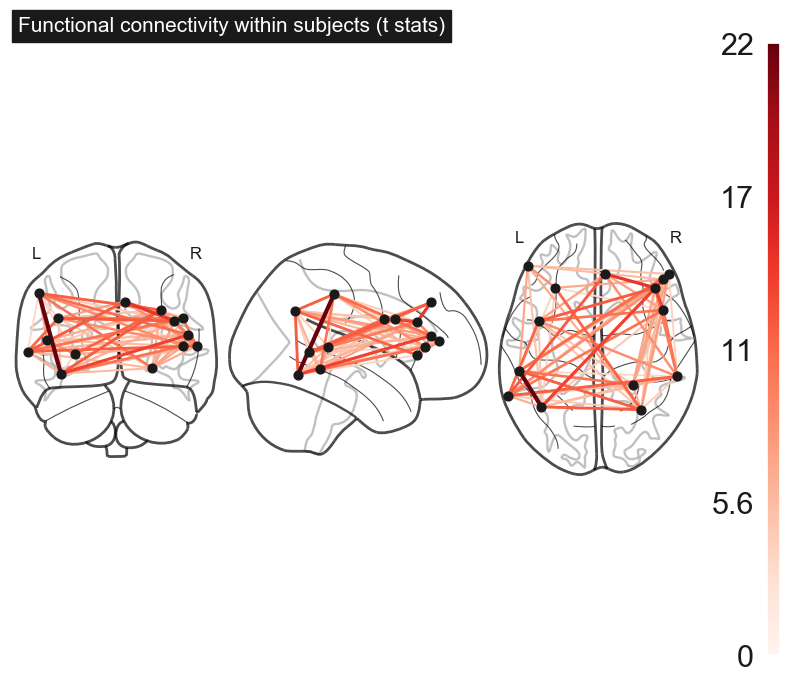

In [85]:
f, ax = plt.subplots(1,1, figsize = (10, 9), dpi=100)

connectome = plotting.plot_connectome(adjacency_matrix=M_sig_sym,
                         node_coords=np.array(list(EU_dict.values())),
                         edge_threshold=None,
                         edge_cmap='Reds',
                         colorbar=True,
                         axes=ax,
                         edge_vmin=0,
                         title='Functional connectivity within subjects (t stats)',
                         edge_vmax=np.max(M_sig_sym),
                         node_size=40,
                         node_color='k'
                         
                         );



# Part II. Granger Causality

TODO: continue analysis for voxel pairs. Make sure to use the correct order (see dicts)


---

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

The null hypothesis for all four test is that the coefficients corresponding to past values of the second time series are zero.

In [73]:
residuals_roi_voxels.shape

(1698, 14, 8)

In [74]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

data = residuals_roi_voxels[:, [0,7]]

data.shape

(1698, 2, 8)

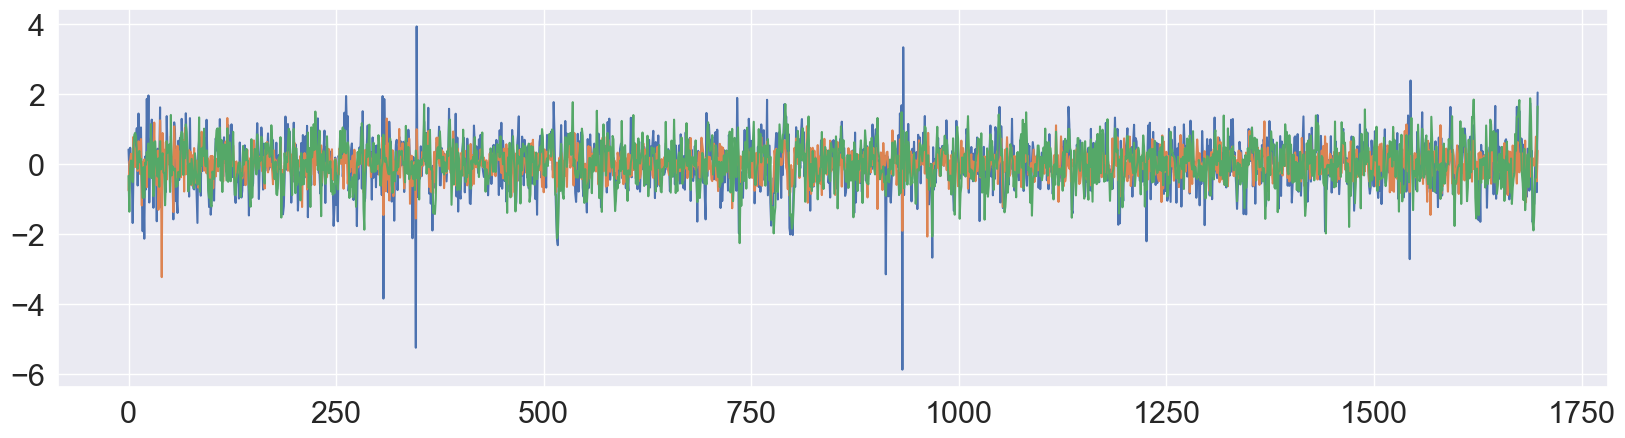

In [75]:
plt.figure(figsize=(20, 5), dpi=100)
plt.plot(residuals_roi_voxels[:,0,0])
plt.plot(residuals_roi_voxels[:,1,0])
plt.plot(residuals_roi_voxels[:,10,0]);

In [76]:
residuals_roi_voxels[:,7].shape

(1698, 8)

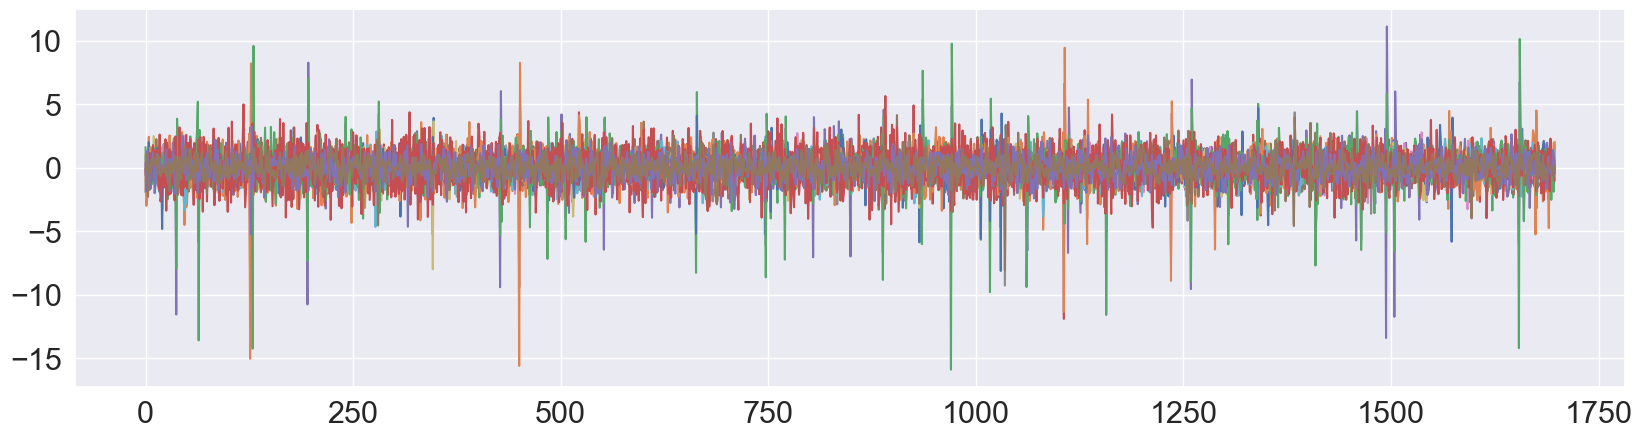

In [77]:
plt.figure(figsize=(20, 5), dpi=100)
plt.plot(residuals_roi_voxels[:,0])
plt.plot(residuals_roi_voxels[:,7]);